# ACTIVIDAD 2 - REDES DE NEURONAS Y MÁQUINAS DE VECTOR DE SOPORTE

Esta actividad trata sobre la comparación entre las máquinas de vector de soporte y las redes neuronales, hecha por Albert Marquillas Estruch.

# 1. Preparación del entorno 

#### Importación de librerías

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

# Representacion y graficos
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import  plot_confusion_matrix, accuracy_score, confusion_matrix
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

#### Cargar el dataframe

In [2]:
df = pd.read_csv("datasets_train.csv")

# 2. Análisis descriptivo de los datos

#### Muestra de los datos

In [3]:
df[:5]

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


##### Variables categóricas y numéricas 

Se separan las variables categóricas de las variables numéricas del dataset de esta actividad y se muestran los dos grupos por pantalla.

In [4]:
numericos = [f for f in df.columns if df.dtypes[f] != 'object']

categoricos = [f for f in df.columns if df.dtypes[f] == 'object']

print("Datos categoricos: {}".format(categoricos))
print()
print("Datos numericos: {}".format(numericos))

Datos categoricos: []

Datos numericos: ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'price_range']


Se puede ver como todas las variables son marcadas como numéricas, ya que las que en realidad son categóricas tienen números asignados, y realizar la separación no es tan simple. Para ello será necesario trabajar los datos de forma correcta.

Como primera premisa para la separación, si una variable tiene más de 10 valores distintos se considerará numérica, ya que más de 10 clases ya tendría demasiada cantidad de ellas. 

Por otro lado, si la variable tiene 2 clases, se considerará directamente como categórica, ya que son solo 2 opciones y no sería acertado tener esas variables como numéricas.

Para el resto de variables, se analizarán y según la característica se decidirá que sean numéricas o no.

In [5]:
df.nunique().sort_values(ascending=False)

ram              1562
px_height        1137
px_width         1109
battery_power    1094
mobile_wt         121
int_memory         63
clock_speed        26
pc                 21
fc                 20
sc_w               19
talk_time          19
sc_h               15
m_dep              10
n_cores             8
price_range         4
wifi                2
three_g             2
four_g              2
dual_sim            2
touch_screen        2
blue                2
dtype: int64

Utilizando las suposiciones comentadas, solo quedan por revisar las variables de `m_dep`, `n_cores` y `price_range`. Para ello se van a mostrar estas variables solas para poder determinar del tipo que son.

In [6]:
df[["m_dep","n_cores","price_range"]]

,m_dep,n_cores,price_range
0,0.6,2,1
1,0.7,3,2
2,0.9,5,2
3,0.8,6,2
4,0.6,2,1
...,...,...,...
1995,0.8,6,0
1996,0.2,4,2
1997,0.7,8,3
1998,0.1,5,0


En este caso, como la variable de `m_dep` tiene valores menores a 1, se considera numérica, ya que no tendría sentido una variable categórica con estos valores.

La variable `n_cores`, también se considerará numérica, ya que el número de cores en un móvil es un valor numérico que varía entre ellos y no se considera que pueda pertenecer a una clase.

Por último, la variable de `price_range`, que será la variable de interés, se puede intuir que será una variable categórica debido a que categoriza los rangos de los precios en 4 clases distintas, por lo tanto, esta será considerada como categórica.

A continuación se convierten a categóricas las variables que no lo son.

In [7]:
transform_vars = ["blue","price_range","wifi","three_g","four_g","dual_sim","touch_screen"]

for col in transform_vars:
    df[col] = df[col].astype('object')

Una vez las variables están correctamente asignadas, se vuelve a mostrar la división.

In [8]:
numericos = [f for f in df.columns if df.dtypes[f] != 'object']

categoricos = [f for f in df.columns if df.dtypes[f] == 'object']

print("Datos categoricos: {}".format(categoricos))
print()
print("Datos numericos: {}".format(numericos))

Datos categoricos: ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi', 'price_range']

Datos numericos: ['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time']


#### Datos estadísticos de las variables numéricas

De las variables numéricas se muestran los distintos datos de media, mediana, mínimo, máximo y cuartiles.

In [9]:
df.describe()

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1238.518500,1.522250,4.309500,32.046500,0.501750,140.249000,4.520500,9.916500,645.108000,1251.515500,2124.213000,12.306500,5.767000,11.011000
std,439.418206,0.816004,4.341444,18.145715,0.288416,35.399655,2.287837,6.064315,443.780811,432.199447,1084.732044,4.213245,4.356398,5.463955
min,501.000000,0.500000,0.000000,2.000000,0.100000,80.000000,1.000000,0.000000,0.000000,500.000000,256.000000,5.000000,0.000000,2.000000
25%,851.750000,0.700000,1.000000,16.000000,0.200000,109.000000,3.000000,5.000000,282.750000,874.750000,1207.500000,9.000000,2.000000,6.000000
50%,1226.000000,1.500000,3.000000,32.000000,0.500000,141.000000,4.000000,10.000000,564.000000,1247.000000,2146.500000,12.000000,5.000000,11.000000
75%,1615.250000,2.200000,7.000000,48.000000,0.800000,170.000000,7.000000,15.000000,947.250000,1633.000000,3064.500000,16.000000,9.000000,16.000000
max,1998.000000,3.000000,19.000000,64.000000,1.000000,200.000000,8.000000,20.000000,1960.000000,1998.000000,3998.000000,19.000000,18.000000,20.000000


Viendo estos resultados, ya se puede ver como en las variables numéricas no hay valores faltantes, por lo tanto, la parte correspondiente al tratamiento de missing no será requerida.

#### Datos de las variables categóricas

Para las variables se muestran también los datos estadistícos de estas.

In [10]:
df.describe(include='object')

,blue,dual_sim,four_g,three_g,touch_screen,wifi,price_range
count,2000,2000,2000,2000,2000,2000,2000
unique,2,2,2,2,2,2,4
top,0,1,1,1,1,1,3
freq,1010,1019,1043,1523,1006,1014,500


Todas las variables categóricas menos la de `price_range` tienen solo dos categorías, por lo tanto las proporciones de cada clase se pueden extraer de este resumen, se puede ver como estas categorías están muy balanceadas con casi una repartición de 50% en cada clase, pero para la categoría de interés de rango de precio no es posible, por lo tanto, se muestra el resumen de esta a continuación.

In [11]:
pd.value_counts(df["price_range"])

3    500
2    500
1    500
0    500
Name: price_range, dtype: int64

Se puede ver que tiene una distribución perfecta de las categorías, está totalmente balanceada.

#### Correlaciones de los datos numéricos

Primero de todo, se encuentra la matriz de correlación con las variables numéricas.

In [12]:
df.corr(method="pearson")

,battery_power,clock_speed,fc,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time
battery_power,1.000000,0.011482,0.033334,-0.004004,0.034085,0.001844,-0.029727,0.031441,0.014901,-0.008402,-0.000653,-0.029959,-0.021421,0.052510
clock_speed,0.011482,1.000000,-0.000434,0.006545,-0.014364,0.012350,-0.005724,-0.005245,-0.014523,-0.009476,0.003443,-0.029078,-0.007378,-0.011432
fc,0.033334,-0.000434,1.000000,-0.029133,-0.001791,0.023618,-0.013356,0.644595,-0.009990,-0.005176,0.015099,-0.011014,-0.012373,-0.006829
int_memory,-0.004004,0.006545,-0.029133,1.000000,0.006886,-0.034214,-0.028310,-0.033273,0.010441,-0.008335,0.032813,0.037771,0.011731,-0.002790
m_dep,0.034085,-0.014364,-0.001791,0.006886,1.000000,0.021756,-0.003504,0.026282,0.025263,0.023566,-0.009434,-0.025348,-0.018388,0.017003
mobile_wt,0.001844,0.012350,0.023618,-0.034214,0.021756,1.000000,-0.018989,0.018844,0.000939,0.000090,-0.002581,-0.033855,-0.020761,0.006209
n_cores,-0.029727,-0.005724,-0.013356,-0.028310,-0.003504,-0.018989,1.000000,-0.001193,-0.006872,0.024480,0.004868,-0.000315,0.025826,0.013148
pc,0.031441,-0.005245,0.644595,-0.033273,0.026282,0.018844,-0.001193,1.000000,-0.018465,0.004196,0.028984,0.004938,-0.023819,0.014657
px_height,0.014901,-0.014523,-0.009990,0.010441,0.025263,0.000939,-0.006872,-0.018465,1.000000,0.510664,-0.020352,0.059615,0.043038,-0.010645
px_width,-0.008402,-0.009476,-0.005176,-0.008335,0.023566,0.000090,0.024480,0.004196,0.510664,1.000000,0.004105,0.021599,0.034699,0.006720


Para poder identificar mejor las variables correlacionadas entre sí, se ha realizado un mapa de calor, donde los valores de correlación mayores a 0.75 son mostrados en blanco.

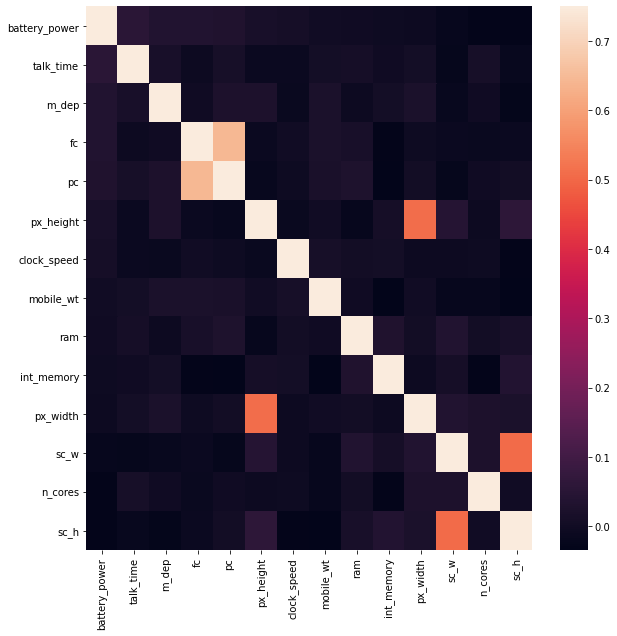

In [13]:
train = df
columns = df.corr(method="pearson")["battery_power"].sort_values(ascending=False)[:].index

corr = train[columns].corr(method="pearson")

plt.figure(figsize=(10,10))
sns.heatmap(corr, vmax=0.75);

Como se puede ver, las variables con ellas mismas tienen correlación máxima, pero las correlaciones más importantes fuera de estas son un total de 3:

* La más alta de las tres cercana al 0.75 de correlación, pero sin llegar se encuentra entre las variables de `pc` y `fc`, esta correlación tiene un valor de 0.644595. Estas dos variables es normal que estén en cierta medida correlacionadas, ya que la primera es la que indica los megapíxeles de la cámara principal y la otra indica los megapíxeles de la cámara frontal, pero estas son independientes y por lo tanto no se eliminará ninguna de las columnas.


* Por otro lado hay correalción entre las variables `px_width` y `px_height`, con un valor de 0.510664. Es entendible que estas variables esten correlacionadas ya que inciden en el mismo elemento, pero no se va a eliminar ninguna columna, ya que no hay suficiente correlación entre ellas.


* La última pareja de variables con alta correlación es la de `sc_w` y `sc_h`, con una correlación de 0.506144. Estas miden la pantalla, es normal que las dos estén correlacionadas, ya que las pantallas suelen tener unas medidas estándar, si siempre hubiera la misma relación de pantalla o se supiera la relación de pantalla de cada móvil, una de las dos se podría eliminar, pero como no se tiene esa situación, ambas columnas se mantienen.

El resto de variables no tienen ningún tipo de correlación entre ellas, la mayoría tiene valores negativos.

# 3. Máquinas de vector de soporte

El primer tipo de modelo que se utilizará para predecir la clase de interés es la de SVM. Para realizar los modelos, tanto en este caso como para las redes de neuronas será importante realizar pruebas de rendimiento realizando cambios en el mismo modelo o bien en los datos de entrenamiento y test.

Pero para poder comparar lo útiles que son estas transformaciones en los datos, primero de todo se creará un modelo sin realizar más cambios que el hecho de modificar las variables categóricas, que no son la de interés, a numéricas, con el propósito de poder usar todas las variables posibles.

#### Numerizar variables categóricas

Un detalle interesante que se puede ver en los datos es que todas las variables categóricas menos la variable a predecir, son de solo dos categorías, cosa que permite solo cambiar su tipo a numérico y ya estarán en el formato adecuado, ya que si se creara una columna nueva por cada una de estas, se crearían columnas totalmente redundantes, ya que con solo 2 clases una sería el inverso del otro, por este motivo, solo se cambia el tipo de la columna.

Por otro lado, la variable a clasificar, podría dejarse en formato numérico o bien en formato de cuatro columnas indicando con 1 o 0 si cada fila pertenece a una de las columnas. El cambio de la variable de interés se realizará en las comparaciones posteriores, en esta primera experimentación se deja en forma de categoría en una única columna.

In [14]:
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import train_test_split, StratifiedKFold

X = df.iloc[:,:-1]
Y = df["price_range"].astype('int64').values

for i in X.columns:
    if X.dtypes[i] == 'object':
        X[i] = X[i].astype('int64')

#### Separación de los datos

Se separan los datos de forma básica, para el conjunto de entrenamiento se usan un 80% de los datos y para el conjunto de test se usa el 20% restante.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#### Crear modelo

Se crea el modelo utilizando máquinas de vector de soporte utilizando el kernel y otras configuraciones por defecto para poder ver los resultados en su forma más básica.

In [16]:
mvs = svm.SVC(random_state = 42)
mvs.fit(X_train,y_train)

SVC(random_state=42)

Una vez se tiene el modelo ya entrenado se procede a encontrar la matriz de confusión y la métrica de exactitud. Para ello se ha creado una función que será útil para el resto de casos.

In [17]:
def getMetricas(modelo,X_test,y_test):
    predicciones = modelo.predict(X_test)
    print("Exactitud: ",accuracy_score(y_test, predicciones))
    disp = plot_confusion_matrix(modelo, X_test, y_test, cmap=plt.cm.Blues)
    disp.ax_.set_title("Matriz de confusión")
    plt.show()

Exactitud:  0.965


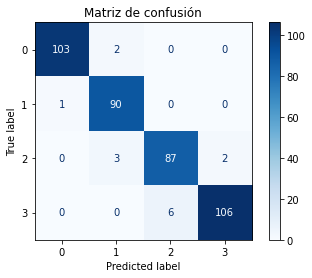

In [18]:
getMetricas(mvs,X_test,y_test)

Como se puede ver, se obtiene una exactitud muy alta, de valor 0.965, lo que indica que este modelo sin usar métodos de mejora ya es muy bueno y se podría considerar totalmente válido para solucionar este problema.

Observando la matriz de confusión, en total solo existen un total de 14 predicciones erróneas que es un error mínimo frente al total de 400 predicciones que corresponde al 20% de los datos. Además los errores se encuentran solo entre las clases cercanas, esto significa que un error de predicción de la clase 0 solo será clasificado en la clase 1 y ya no en la 2 y ni mucho menos en la 3.

En este caso el modelo ya se podría considerar válido, pero como se ha comentado anteriormente, se experimentará con la normalización de los datos y la validación cruzada.

#### Normalización de los datos

Se normalizan los datos utilizando el MinMaxScaler de la librería sklearn, y se obtienen los nuevos conjuntos de entrenamiento y test.

In [19]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(scaled_df, Y, test_size=0.2, random_state=42)

Una vez se han obtenido los conjuntos normalizados, se procede a entrenar el modelo y obtener las métricas de error.

Exactitud:  0.8625


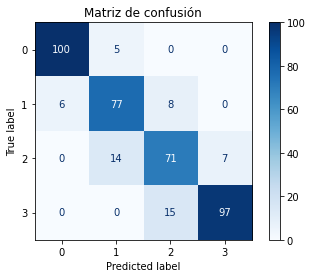

In [20]:
mvs.fit(X_train,y_train)
getMetricas(mvs,X_test,y_test)

En este caso se puede ver como el hecho de realizar la normalización es improducente, ya que se ha obtenido una métrica de exactitud menor que con los datos sin normalizar. Este resultado tiene cierto sentido, ya que el hecho de normalizar los datos, junta mucho más los puntos y es más difícil que el algoritmo encuentre un hiperplano bueno, además el hecho de reducir los valores implica que las variables que antes tenían más peso, al normalizar han perdido ese peso y eso hace que se pierda exactitud en la clasificación.

#### Cambio kernel

Antes de aplicar la validación cruzada a las MVS, se comprobarán los resultados obtenidos cambiando el kernel, para este caso se volverán a usar datos sin normalizar, ya que han dado mejores resultados con el kernel por defecto.

Cabe mencionar que se han probado los distintos kernel posibles, y el que ha dado mejores resultados ha sido el lineal, que es el que se muestra a continuación.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [22]:
mvs = svm.SVC(kernel='linear',random_state = 42)
mvs.fit(X_train,y_train)

SVC(kernel='linear', random_state=42)

Una vez entrenado el modelo de MVS con kernel lineal se procede a observar las métricas de error.

Exactitud:  0.97


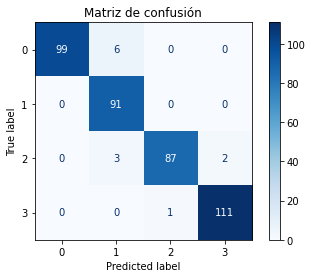

In [23]:
getMetricas(mvs,X_test,y_test)

En este caso, ha mejorado la exactitud en 0.005 por lo tanto el modelo con los datos sin normalizar y con un kernel linear es el que mejores resultados da aunque por un ajustado margen. Un punto negativo que se ha podido detectar del kernel linear es que no es tan rápido crear el modelo como en el caso básico que usa un kernel de función con base radial (rbf).

#### Validación cruzada

Por último, se realiza la validación cruzada de los datos usando el mejor modelo encontrado para MVS, en este caso es la máquina de vector de soporte con un kernel lineal y con los datos sin normalizar.

In [24]:
mvs = svm.SVC(kernel='linear',random_state = 42)

Se crea una función para automatizar la validación cruzada que será de utilidad también para la red neuronal, esta función realiza la validación de modo que hace 5 folds de los datos, esto quiere decir que para cada uno utiliza un 80% de datos para el entrenamiento y un 20% para el test.

In [25]:
def crossValidate(model,X,Y):
    kf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)
    for train_index,test_index in kf.split(X,Y):
        X_train, X_test = X.to_numpy()[train_index], X.to_numpy()[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        model.fit(X_train,y_train)
        predicciones = model.predict(X_test)
        print("Exactitud: ",accuracy_score(y_test, predicciones))    

Se obtienen las distintas exactitudes de la validación cruzada.

In [26]:
crossValidate(mvs,X,Y)

Exactitud:  0.9675
Exactitud:  0.98
Exactitud:  0.9625
Exactitud:  0.9675
Exactitud:  0.9775


Se puede ver como aplicando el método de cross validación las exactitudes son poco variantes y se aproximan bastante al valor de 0.97 obtenido antes. El mejor modelo obtenido es el que da una exactitud de 0.98 que es solo 0.01 mejor que el encontrado al utilizar el kernel lineal.

# 4. Redes neuronales

La siguiente forma de realizar la clasificación es utilizando las redes de neuronas, para estas se va a seguir la misma dinámica que para las máquinas de vector de soporte.

#### Numerizar variables categóricas

En este caso se realiza el mismo primer proceso que en las MVS asignando a las categorías el formato numérico.

In [27]:
X = df.iloc[:,:-1]
Y = df["price_range"].astype('int64').values

for i in X.columns:
    if X.dtypes[i] == 'object':
        X[i] = X[i].astype('int64')

#### Separación de los datos

Se separan los datos en un 80% para el entrenamiento y un 20% para el test.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#### Crear modelo

Para las redes de neuronas, el modelo se va a crear sin especificar ni la función de activación ni las capas ocultas de esta, dejando el modelo con las variables por defecto, solo se asigna el valor a random_state para obtener el mismo resultado siempre que se ejecute de nuevo este proceso.

In [29]:
rn = MLPClassifier(random_state = 42)
rn.fit(X_train,y_train)

MLPClassifier(random_state=42)

Una vez entrenado el modelo, se procede a comprobar las métricas de error.

Exactitud:  0.64


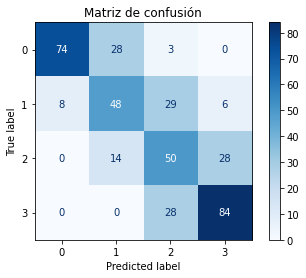

In [30]:
getMetricas(rn,X_test,y_test)

Como se puede ver, en este caso se obtienen unos resultados bastante malos, con una exactitud de solo 0.64, y observando la matriz de confusión, todas las clases tienen muchos valores mal clasificados y hay desviaciones de hasta 2 clases (clasificaciones de la clase 1 son clasificadas como clase 3, entre otras).

Viendo este resultado se descarta totalmente este modelo de clasificación hecho con redes neuronales. Como primera comparación respecto a las MVS, con los datos sin normalizar y con las variables a clasificar en la misma columna, se seleccionaría el modelo de MVS sin ninguna duda.

#### Normalización de los datos

Para las redes neuronales también se van a normalizar los datos para ver si el resultado mejora.

In [31]:
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(X)
scaled_df = pd.DataFrame(scaled_df, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(scaled_df, Y, test_size=0.2, random_state=42)

Se entrena el modelo y se obtienen las métricas de nuevo.

Exactitud:  0.9625


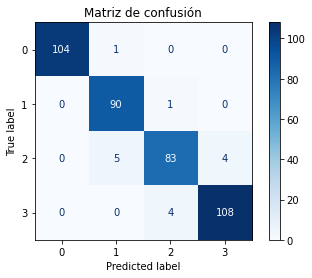

In [32]:
rn.fit(X_train,y_train)
getMetricas(rn,X_test,y_test)

En este caso, la exactitud de la red neuronal ha aumentado en gran medida a diferencia de cuando se ha aplicado la normalización en las MVS. Se obtiene un valor de exactitud de 0.9625, que es prácticamente el mismo valor que se obtiene con MVS sin normalizar, aun así, por un margen mínimo tienen mejor resultado las MVS.

#### Cambio red neuronal

Igual que con las MVS, se van a realizar cambios en la función de activación de la red neuronal para comprobar se existe mejora respecto a la red neuronal por defecto, en este caso se utilizarán los valores normalizados.

Para este caso se han probado las distintas funciones de activación y la que mejores resultados ha dado ha sido la función identidad y es la que se muestra a continuación, pero cabe mencionar que la función tangente hiperbólica ha dado resultados prácticamente igual de buenos.

Los otros parámetros se han dejado los valores por defecto.

In [33]:
rn = MLPClassifier(activation='identity',random_state = 42)
rn.fit(X_train,y_train)

MLPClassifier(activation='identity', random_state=42)

Exactitud:  0.9725


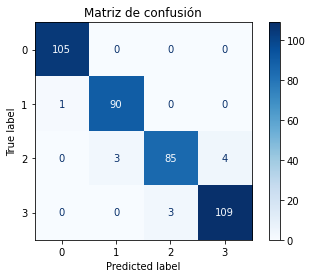

In [34]:
getMetricas(rn,X_test,y_test)

Como se puede ver, la métrica de exactitud es de 0.9725 y es el mayor valor obtenido con las redes neuronales, por lo tanto para la parte de validación cruzada se usará como función de activación la identidad.

#### Validación cruzada

Por último se realiza la validación cruzada, en este caso se realizará con una red neuronal con función de activación del tipo identidad y con los datos normalizados, ya que este formato ha sido el que mejores resultados ha dado.

In [35]:
rn = MLPClassifier(activation='identity',random_state = 42)

Se obtienen las distintas métricas de error.

In [36]:
crossValidate(rn,scaled_df,Y) # Como parametro X se la dan los datos normalizados

Exactitud:  0.9475
Exactitud:  0.96
Exactitud:  0.955
Exactitud:  0.9575
Exactitud:  0.96


En este caso se puede ver como la validación cruzada devuelve buenos valores de exactitud, pero todos son peores al modelo encontrado anterior con la función de activación de tipo identidad. Aunque los resultados son peores, no se encuentran demasiado lejos del resultado de ese modelo.

#### Pruebas extra

Como pruebas extra fuera del análisis general se ha decidido ver como en las redes de neuronas puede afectar el hecho de separar la variable de interés en cuatro columnas diferentes para que la red neuronal de un total de cuatro salidas en vez de una salida con cuatro posibilidades.

Para realizar esto, el primer paso es cambiar las columnas del dataset a cuatro, para ello se usan las variables escaladas que se han obtenido en anteriores pasos.

In [37]:
scaled_df["price_range"] = df["price_range"] #Como las variables normalizadas no tienen price_range se añade
df_encoded = scaled_df.copy(deep=True)
dummy = pd.get_dummies(df_encoded["price_range"])
df_encoded = pd.concat([df_encoded,dummy],axis=1)
df_encoded = df_encoded.drop("price_range", axis=1)

Después de realizar los cambios a la variable de interés, se realiza la separación de los datos de entrenamiento y test como se ha realizado en los otros casos, pero esta vez, las variables de interés son las últimas cuatro del dataset.

In [38]:
X = df_encoded.iloc[:,:-4]
Y = df_encoded.iloc[:,-4:]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Una vez separados los datos solo queda entrenar el modelo, para este caso se han probado distintos modelos con distintos parámetros, y se ha encontrado que los mejores resultados se obtenían aumentando el número total de máximas iteraciones y manteniendo como función de activación la que está por defecto.

In [39]:
rn = MLPClassifier(random_state = 42, max_iter = 1000)
rn.fit(X_train,y_train)

MLPClassifier(max_iter=1000, random_state=42)

En este caso no es posible usar la función para la matriz de confusión, ya que se deben juntar las predicciones en una sola columna, para ello, si para dos clases el modelo ha predicho que la fila pertenece a ambas se ha seleccionado la de menor valor.

In [40]:
results = pd.DataFrame(data=rn.predict(X_test))

results["price_range"] = results[0] # Solo sirve para crear la columna

# Resultados de predicciones
for i in range(len(results)):
    if results[0][i] == 1:
        results["price_range"][i]=0
    elif results[1][i] == 1:
        results["price_range"][i]=1
    elif results[2][i] == 1:
        results["price_range"][i]=2
    else:
        results["price_range"][i]=3
        
results["price_range_real"] = results[0] # Solo sirve para crear la columna
# Resultados reales en una sola columna
for j,i in enumerate(y_test[0]):
    if i == 1:
        results["price_range_real"][j]=0
for j,i in enumerate(y_test[1]):
    if i == 1:
        results["price_range_real"][j]=1
for j,i in enumerate(y_test[2]):
    if i == 1:
        results["price_range_real"][j]=2
for j,i in enumerate(y_test[3]):
    if i == 1:
        results["price_range_real"][j]=3

Una vez se tienen tanto los valores predichos como los valores reales en una sola columna cada uno, solo queda encontrar la exactitud y la matriz de confusión, cabe mencionar que en este caso no se puede representar la matriz de confusión utilizando la misma forma que para las otras, ya que en las demás, se creaba utilizando el modelo y la misma función de sklearn la representaba de forma correcta.

Exactitud:  0.935


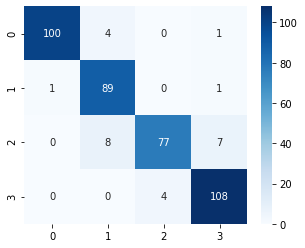

In [41]:
print("Exactitud: ",accuracy_score(results["price_range_real"], results["price_range"]))
conf = confusion_matrix(results["price_range_real"], results["price_range"])
plt.figure(figsize=(5,4))
sns.heatmap(conf, cmap="Blues", fmt='', annot=True);

El valor obtenido es peor que en el mejor caso de las redes de neuronas, aunque un valor de exactitud de 0.935 es bastante bueno. Observando la matriz de confusión, se puede identificar una razón de error, esta es que en la columna de la clase 3 hay más de un valor asignado, dando errores de que valores que tendrían que ir a la clase 0 van a la clase 3. Esto es debido a que estos casos específicos la red neuronal no los ha clasificado en ninguna clase, y en el momento en que se han juntado las distintas columnas, si ninguna de ellas no tiene ningún 1, se asignaba a la clase 3.

Después de realizar esta prueba, se mantiene como mejor modelo el obtenido anteriormente con la función de activación identidad y con la variable de interés en una misma clase.

# 5. Conclusiones

Comparando ambos clasificadores, en general se han obtenido mejores resultados con las máquinas de vector de soporte.

Con las MVS el mejor valor de exactitud obtenido ha sido de 0.98 en la validación cruzada con kernel lineal, mientras que con las redes neuronales el máximo valor de exactitud ha sido de 0.9725 utilizando como función de activación la identidad. La diferencia es prácticamente mínima entre los dos modelos, y por lo tanto ambos modelos son completamente válidos para realizar las predicciones.

En este caso se utilizaría el modelo de MVS, ya que ha sido el que mejor valor de exactitud ha devuelto.

El hecho de que en los diferentes modelos entrenados se hayan obtenido buenos valores de exactitud y las matrices de correlaciones hayan sido buenas, sin tener en cuenta el modelo de red neuronal con los datos sin normalizar, se debe en gran parte a que el dataset era muy bueno, no tenía datos faltantes y las clases estaban perfectamente balanceadas.

Cabe mencionar que ambos modelos tienen ciertas ventajas y desventajas, una clara ventaja que comparten es que ambos son capaces de realizar clasificaciones con muy buenos resultados, pero pot otro lado, ambos son costosos computacionalmente y además son modelos de caja negra que no se puede saber como realizan el proceso de clasificación. Un detalle a destacar de las redes neuronales es que estas pueden clasificar con más de una salida como se ha podido ver en la última experimentación aunque no haya mejorado los resultados finales, en otros casos puede ser de gran utilidad.